# Getting data

In [1]:
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import tensorflow as tf
import pandas as pd
import numpy as np

df = pd.read_csv("../input/df-notnull-notdup-noturl/df_notnull_notdup.csv")

sequences, label = df['desc_nonUrl'], df['label']
X_train, X_test, y_train, y_test = train_test_split(sequences, label, stratify=label, 
                                                    test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, 
                                                test_size=0.1, random_state=42)

print(f'Train size : {len(X_train)}')
print(f'Test  size : {len(X_test)}')
print(f'val size   : {len(X_val)}')
SHUFFLE_BUFFER_SIZE = len(X_train)

Train size : 8640
Test  size : 4115
val size   : 960


# Load the pretrained Tokenizer, Transformer

In [2]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint, output_hidden_states=True)
bert.distilbert.trainable = False  # freeze transformer

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# Prepare the data

In [3]:
train_set = {'seqs':X_train.values.tolist(), 'targets':y_train.values.tolist()}
test_set  = {'seqs':X_test.values.tolist(),  'targets':y_test.values.tolist()}
val_set = {'seqs':X_val.values.tolist(),  'targets':y_val.values.tolist()}

## Tokenization

In [4]:
def tokenize_seqs(seqs):
    encoded = tokenizer(
        seqs,
        padding=True,
        truncation=True,
        return_tensors='tf',
    )
    return encoded.data
tokenized_train = tokenize_seqs(train_set['seqs'])
tokenized_test = tokenize_seqs(test_set['seqs'])
tokenized_val = tokenize_seqs(val_set['seqs'])

In [5]:
tokenized_train

{'input_ids': <tf.Tensor: shape=(8640, 512), dtype=int32, numpy=
 array([[ 101, 1037, 3145, ...,    0,    0,    0],
        [ 101, 2011, 1018, ...,    0,    0,    0],
        [ 101, 2206, 1996, ...,    0,    0,    0],
        ...,
        [ 101, 2852, 1012, ...,    0,    0,    0],
        [ 101, 2054, 2003, ...,    0,    0,    0],
        [ 101, 3419, 1010, ...,    0,    0,    0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(8640, 512), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

## Label encoding

In [6]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_set['targets'])
y_test_encoded  = label_encoder.transform(test_set['targets'])
y_val_encoded  = label_encoder.transform(val_set['targets'])

y_train_ohe = tf.one_hot(y_train_encoded, depth=len(label_encoder.classes_))
y_test_ohe  = tf.one_hot(y_test_encoded, depth=len(label_encoder.classes_))
y_val_ohe  = tf.one_hot(y_val_encoded, depth=len(label_encoder.classes_))

In [7]:
print(label_encoder.classes_)
np.save("fineTune_classes", label_encoder.classes_)

['business' 'comedy' 'cooking' 'crime' 'culture' 'kid' 'lifestyle'
 'machine learning' 'politics' 'sport']


In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((tokenized_train, y_train_ohe))
test_dataset  = tf.data.Dataset.from_tensor_slices((tokenized_test,  y_test_ohe))
val_dataset  = tf.data.Dataset.from_tensor_slices((tokenized_val,  y_val_ohe))

BATCH_SIZE = 16
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset  = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset  = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# Modeling

In [9]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Bidirectional, GRU, Input

def get_model():
    max_seq_length = tokenizer.model_max_length
    n_classes = len(label_encoder.classes_)

    input_ids = Input(shape=(max_seq_length,),dtype='int32', name="input_ids")
    attention_mask = Input(shape=(max_seq_length,),dtype='int32', name="attention_mask")

    transformer_output = bert({'input_ids':input_ids, 'attention_mask':attention_mask})  
    
    last_hidden_state = transformer_output['last_hidden_state']
    # Model Head
    bi_gru = Bidirectional(GRU(64))(last_hidden_state)
    h1 = tf.keras.layers.Dense(16, activation='relu')(bi_gru)
    dropout = tf.keras.layers.Dropout(0.2)(h1)
    output = tf.keras.layers.Dense(n_classes, activation='softmax', name="outputs")(dropout)

    new_model = tf.keras.models.Model(inputs = [input_ids, attention_mask], 
                                      outputs = output)
    
    new_model.compile(tf.keras.optimizers.Adam(learning_rate=0.003), 
                      loss=CategoricalCrossentropy(from_logits=False), 
                      metrics=['accuracy'])

    return new_model

## Train the model

In [10]:
new_model = get_model()
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          320256      tf_distil_bert_model[0][7]   

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, 
                                              patience=5, restore_best_weights=False)

# Do not specify the batch_size if your data is in the form of datasets,
history = new_model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=20,
                        callbacks=[early_stop])

Epoch 1/20
540/540 [==============================] - 151s 255ms/step - loss: 2.0565 - accuracy: 0.2408 - val_loss: 1.0508 - val_accuracy: 0.6417
Epoch 2/20
540/540 [==============================] - 135s 251ms/step - loss: 1.1481 - accuracy: 0.6041 - val_loss: 0.7142 - val_accuracy: 0.7875
Epoch 3/20
540/540 [==============================] - 135s 251ms/step - loss: 0.7731 - accuracy: 0.7407 - val_loss: 0.5293 - val_accuracy: 0.8385
Epoch 4/20
540/540 [==============================] - 135s 250ms/step - loss: 0.6086 - accuracy: 0.7908 - val_loss: 0.4552 - val_accuracy: 0.8635
Epoch 5/20
540/540 [==============================] - 135s 251ms/step - loss: 0.4926 - accuracy: 0.8263 - val_loss: 0.3884 - val_accuracy: 0.8781
Epoch 6/20
540/540 [==============================] - 135s 251ms/step - loss: 0.3888 - accuracy: 0.8697 - val_loss: 0.4372 - val_accuracy: 0.8698
Epoch 7/20
540/540 [==============================] - 135s 251ms/step - loss: 0.3765 - accuracy: 0.8712 - val_loss: 0.4258 -

## Save model
By using SavedModel format → https://www.tensorflow.org/guide/saved_model

In [12]:
# Saved model
tf.saved_model.save(new_model, "fine-tuned-distrilled-bert")

In [13]:
# Zipping saved model folder
!tar -zcvf "fine-tuned-distrilled-bert-12Aug2208.tar.gz" "/kaggle/working/fine-tuned-distrilled-bert"

tar: Removing leading `/' from member names
/kaggle/working/fine-tuned-distrilled-bert/
/kaggle/working/fine-tuned-distrilled-bert/assets/
/kaggle/working/fine-tuned-distrilled-bert/saved_model.pb
/kaggle/working/fine-tuned-distrilled-bert/variables/
/kaggle/working/fine-tuned-distrilled-bert/variables/variables.index
/kaggle/working/fine-tuned-distrilled-bert/variables/variables.data-00000-of-00001


## Test Reload model

In [14]:
loaded_model = tf.saved_model.load("fine-tuned-distrilled-bert")
infer = loaded_model.signatures["serving_default"]
print(infer)

ConcreteFunction signature_wrapper(*, input_ids, attention_mask)
  Args:
    attention_mask: int32 Tensor, shape=(None, 512)
    input_ids: int32 Tensor, shape=(None, 512)
  Returns:
    {'outputs': <1>}
      <1>: float32 Tensor, shape=(None, 10)


In [15]:
labeling = infer(attention_mask=tokenized_test['attention_mask'][:2], 
                 input_ids=tokenized_test['input_ids'][:2])

print("Predicted proba :",labeling)
print("\nCheck sum :", tf.reduce_sum(labeling['outputs']))

Predicted proba : {'outputs': <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[2.4615554e-03, 6.7581269e-09, 5.4267210e-05, 1.4940582e-11,
        1.2185089e-03, 5.3880327e-11, 1.8712670e-05, 9.9624664e-01,
        1.2781814e-08, 1.8195030e-07],
       [4.6339068e-01, 1.8531788e-05, 2.2006057e-05, 2.3142245e-06,
        1.7814012e-04, 1.4582944e-02, 2.7127815e-05, 7.0100964e-07,
        5.2177757e-01, 2.6920155e-08]], dtype=float32)>}

Check sum : tf.Tensor(1.9999999, shape=(), dtype=float32)


In [16]:
y_true = tf.argmax(y_test_ohe[:2], axis=1).numpy()
y_pred = tf.argmax(labeling['outputs'], axis=1).numpy()

print(f'(y_true, y_pred) = {(y_true,y_pred)}')

(y_true, y_pred) = (array([7, 8]), array([7, 8]))


## Evaluate with test set

In [17]:
from sklearn.metrics import classification_report

results = []

for i in range(0,len(X_test),100):
    try:
        y_pred = infer(attention_mask=tokenized_test['attention_mask'][i:i+100], 
                         input_ids=tokenized_test['input_ids'][i:i+100])
        y_pred = tf.argmax(y_pred['outputs'], axis=1).numpy().ravel().tolist()
        results+=y_pred
    except Exception as e:
        print(e)
    finally:
        print(i, end='->')

print("FineTuning")
print(classification_report(y_test_encoded, results))

0->100->200->300->400->500->600->700->800->900->1000->1100->1200->1300->1400->1500->1600->1700->1800->1900->2000->2100->2200->2300->2400->2500->2600->2700->2800->2900->3000->3100->3200->3300->3400->3500->3600->3700->3800->3900->4000->4100->FineTuning
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       455
           1       0.80      0.89      0.84       405
           2       0.68      0.76      0.72       289
           3       0.92      0.89      0.90       445
           4       0.78      0.65      0.71       355
           5       0.85      0.95      0.90       568
           6       0.79      0.81      0.80       496
           7       0.86      0.77      0.81       311
           8       0.89      0.90      0.90       420
           9       0.93      0.93      0.93       371

    accuracy                           0.84      4115
   macro avg       0.84      0.83      0.83      4115
weighted avg       0.84      0.84      0.84  

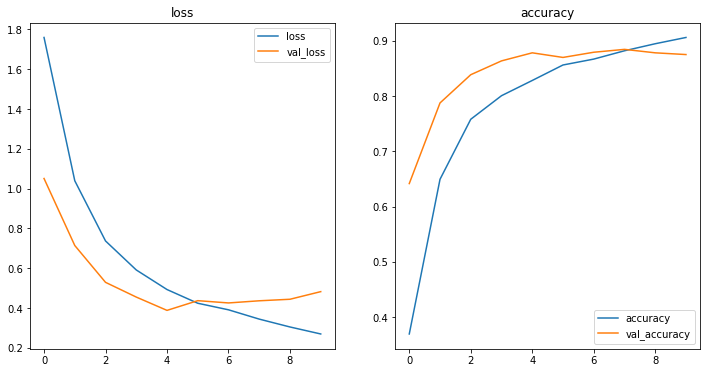

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,6))
EPOCHS=len(history.history['loss'])
ax[0].plot(list(range(EPOCHS)), history.history['loss'], label='loss')
ax[0].plot(list(range(EPOCHS)), history.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend(loc='upper right')

ax[1].plot(list(range(EPOCHS)), history.history['accuracy'], label='accuracy')
ax[1].plot(list(range(EPOCHS)), history.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('accuracy')
ax[1].legend(loc='lower right')
plt.show()